In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
import numpy as np

In [2]:
# 网络设置
class EdgeGAT(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim, device):
        super(EdgeGAT, self).__init__()
        
        self.input_dim = input_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        #权重矩阵W1,W2,每个head都需要一个
        self.node_fc1 = nn.Linear(input_dim, hidden_dim)
        self.edge_fc1 = nn.Linear(edge_dim, hidden_dim)
        self.attention_scores1 = nn.Linear(3*hidden_dim, 1)
        self.node_fc2 = nn.Linear(input_dim, hidden_dim)
        self.edge_fc2 = nn.Linear(edge_dim, hidden_dim)
        self.attention_scores2 = nn.Linear(3*hidden_dim, 1)
        self.node_fc3 = nn.Linear(input_dim, hidden_dim)
        self.edge_fc3 = nn.Linear(edge_dim, hidden_dim)
        self.attention_scores3 = nn.Linear(3*hidden_dim, 1)
        self.node_fc4 = nn.Linear(input_dim, hidden_dim)
        self.edge_fc4 = nn.Linear(edge_dim, hidden_dim)
        self.attention_scores4 = nn.Linear(3*hidden_dim, 1)

        # 输出MLP
        self.output_fc = nn.Sequential(
            #nn.Linear(hidden_dim, 128),
            #nn.ReLU(),
            #nn.Linear(128, output_dim)
            nn.Linear(3*hidden_dim, output_dim)
        )

    def forward(self, data):
        #原始数据
        x = data.x.to(self.device)
        edge_index = data.edge_index.to(self.device)
        edge_attr = data.edge_attr.to(self.device)
        
        # 拼接
        row, col = edge_index
        #row是终点i，col是起点j

        #第一层GAT,head=1
        x1 = self.node_fc1(x)
        edge1 = self.edge_fc1(edge_attr)
        features1 = torch.cat([x1[row], x1[col], edge1], dim=-1)
        scores1 = F.leaky_relu(self.attention_scores1(features1).squeeze(-1))
        scores1 = torch.exp(scores1)
        aaa1  = torch.zeros_like(x[:,0]).scatter_add_(0, row, scores1)
        alpha1 = scores1/aaa1[row]
        #第一层GAT,head=2
        x2 = self.node_fc2(x)
        edge2 = self.edge_fc2(edge_attr)
        features2 = torch.cat([x2[row], x2[col], edge2], dim=-1)
        scores2 = F.leaky_relu(self.attention_scores2(features2).squeeze(-1))
        scores2 = torch.exp(scores2)
        aaa2  = torch.zeros_like(x[:,0]).scatter_add_(0, row, scores2)
        alpha2 = scores2/aaa2[row]
        #第一层GAT,head=3
        x3 = self.node_fc3(x)
        edge3 = self.edge_fc3(edge_attr)
        features3 = torch.cat([x3[row], x3[col], edge3], dim=-1)
        scores3 = F.leaky_relu(self.attention_scores3(features3).squeeze(-1))
        scores3 = torch.exp(scores3)
        aaa3  = torch.zeros_like(x[:,0]).scatter_add_(0, row, scores3)
        alpha3 = scores3/aaa3[row]
        
        messages1 = alpha1.unsqueeze(-1) * (x1[col] + edge1)  
        aggregated1 = torch.zeros_like(x1).scatter_add_(0, row.unsqueeze(-1).expand(-1, self.hidden_dim), messages1) 
        x1 = F.relu(aggregated1)
        messages2 = alpha2.unsqueeze(-1) * (x2[col] + edge2)  
        aggregated2 = torch.zeros_like(x2).scatter_add_(0, row.unsqueeze(-1).expand(-1, self.hidden_dim), messages2) 
        x2 = F.relu(aggregated2)
        messages3 = alpha3.unsqueeze(-1) * (x3[col] + edge3)  
        aggregated3 = torch.zeros_like(x3).scatter_add_(0, row.unsqueeze(-1).expand(-1, self.hidden_dim), messages3) 
        x3 = F.relu(aggregated3)
        
        x = torch.concat([x1,x2,x3],dim = -1)
        #print(x.shape)
        '''
        #第二次GAT
        eff_features = torch.cat([x[row], x[col], edge_transformed], dim=-1)
        alpha_list = self.multi_attn2(x, eff_features, row)
        alpha = alpha_list[0]
        messages = alpha.unsqueeze(-1) * (x_transformed[col] + edge_transformed)  # M x hidden_dim
        aggregated = torch.zeros_like(x_transformed).scatter_add_(0, row.unsqueeze(-1).expand(-1, self.hidden_dim), messages)
        x = F.relu(aggregated) '''

        
        # 输出
        #out = self.output_fc(x)  # N x output_dim
        out = torch.sigmoid(self.output_fc(x))
        return out

In [3]:
def load_and_preprocess_data(edge_path, adj_path, label_path, label_path2, train_size=21000, test_size=1600):

    # 加载数据并截取前 13000 个样本
    edges = torch.tensor(np.load(edge_path)[:train_size + test_size], dtype=torch.float32)  # (13000, 40, 40)
    adj = torch.tensor(np.load(adj_path)[:train_size + test_size], dtype=torch.float32)    # (13000, 40, 40)
    labels = torch.tensor(np.load(label_path)[:train_size + test_size], dtype=torch.float32)  # (13000, 40)
    labels2 = torch.tensor(np.load(label_path2)[:train_size + test_size], dtype=torch.float32)  # (13000,)
    
    # 确保边特征矩阵的形状为 (13000, 40, 40, 1)
    edges = edges.unsqueeze(-1)  # 添加最后一个维度

    # 图数据集列表
    graph_data = []

    for i in range(edges.size(0)):  # 遍历每张图
        # 获取当前图的邻接矩阵和边特征矩阵
        adj_matrix = adj[i]  # 邻接矩阵 (40, 40)
        edge_features = edges[i]  # 边特征矩阵 (40, 40, 1)

        # 将稠密邻接矩阵转换为稀疏表示
        edge_index, _ = dense_to_sparse(adj_matrix)  # 边索引 (2, num_edges)

        # 提取与邻接矩阵对应的边特征
        edge_attr = edge_features[edge_index[0], edge_index[1]]  # (num_edges, 1)

        # 初始化节点特征
        node_features = torch.zeros((adj_matrix.size(0), 2), dtype=torch.float32)  # (40, 2)
        degree = adj_matrix.sum(dim=-1)  # 节点度
        sigedges=torch.sum(edge_features.squeeze(-1), dim=1)  # (40, 1)
        degree_inverse = 1.0 / degree
        #标准化
        degree_inverse /= torch.max(degree_inverse)
        sigedges = (sigedges-torch.mean(sigedges))/torch.std(sigedges)
        #degree_inverse = (degree_inverse-torch.min(degree_inverse))/(torch.max(degree_inverse)-torch.min(degree_inverse))
        #print(degree_inverse)
        node_features[:, 0] = degree_inverse  # 节点度信息
        node_features[:, 1] = sigedges

        # 获取标签
        label = labels[i].unsqueeze(-1)  # (40,1)

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=label)
        graph_data.append(data)

    # 划分训练集和测试集
    train_data = graph_data[:train_size]
    test_data = graph_data[train_size:train_size + test_size]
    labels2 = labels2[train_size:train_size + test_size]
    return train_data, test_data, labels2

In [4]:
#梯度累积训练
def train2(model, train_data, optimizer, criterion):
    model.train()
    accumulation_steps=8
    total_loss = 0
    data_num =0
    losses = np.zeros(21000)
    for data in train_data:
        step = data_num
        data_num+=1
        #optimizer.zero_grad()

            # Forward pass
        out = model(data).squeeze(-1)
        label= data.y.squeeze(-1).to('cuda:0')

        # Compute loss
        loss = criterion(out, label)
        total_loss += loss.item()
        losses[step] = loss
        loss = loss/accumulation_steps
        loss.backward()
        
        if data_num % accumulation_steps == 0 or data_num == len(train_data):
            optimizer.step()  # 更新参数
            optimizer.zero_grad()  # 清空累积的梯度

        
        # if data_num % 1000 == 0:
        #     for name, param in model.named_parameters():
        #         print(f'Parameter:{name}')
        #         print(f'Gradient: {param.grad}')
        # print(loss.item())
        

    return total_loss / data_num, losses

In [5]:
#梯度累积训练
def train(model, train_data, optimizer, criterion):
    model.train()
    total_loss = 0
    data_num =0
    losses = np.zeros(21000)
    for data in train_data:
        # for mini_step in range(accumulated_gradient_steps):
        data_num+=1
        optimizer.zero_grad()

            # Forward pass
        out = model(data).squeeze(-1)
        label= data.y.squeeze(-1).to('cuda:0')

        # Compute loss
        loss = criterion(out, label)
        losses[data_num-1] = loss
        loss.backward()
        optimizer.step()
        # if data_num % 1000 == 0:
        #     for name, param in model.named_parameters():
        #         print(f'Parameter:{name}')
        #         print(f'Gradient: {param.grad}')
        # print(loss.item())
        total_loss += loss.item()

    return total_loss / data_num, losses

In [6]:
def evaluate(model, test_data, labels2, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    data_num=0
    err_max =0
    err_tot =0
    with torch.no_grad():
        for data in test_data:
            
            data_num+=1
            # Forward pass
            out = model(data).squeeze(-1)
            label = data.y.squeeze(-1).to('cuda:0')
            # Compute loss
            loss = criterion(out,label )
            total_loss += loss.item()

            # Evaluate accuracy
            pred = (out > 0.5).float()
            err  = abs(out.sum().item()/40 - labels2[data_num-1])
            err_tot +=err
            if abs(label.sum().item()/40 - labels2[data_num-1])>0.01:
                print('error!')
            if err>err_max:
                err_max = err
            correct += (pred == label).sum().item()/40
            

    accuracy = correct / data_num
    return total_loss / data_num, accuracy, err_max, err_tot/data_num

In [7]:
from torch.optim.lr_scheduler import StepLR

N = 40  
input_dim = 2
edge_dim = 1
hidden_dim = 16
output_dim = 1
    
# 加载数据
train_data, test_data , labels2 = load_and_preprocess_data("/root/edges.npy", "/root/adj.npy", "/root/labels.npy", "/root/labels2.npy")
print('Loaded!')

device = 'cuda:0'
# 初始化模型、优化器和损失函数
model = EdgeGAT(input_dim, edge_dim, hidden_dim, output_dim, device).to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()

scheduler = StepLR(optimizer, step_size=2, gamma=0.3)  # Reduce learning rate by a factor of 0.1 every 1 epochs
print('Initialized!')


Loaded!
Initialized!


In [8]:
epoch =0
train_loss = 0
test_loss, accuracy,error, merror = evaluate(model, test_data,labels2, criterion)
print(f'Epoch {epoch}:  No Train Loss , Test Loss = {test_loss:.4f}, Accuracy = {accuracy*100:.2f}%, MAXERROR = {error:.4f},MEANERROR = {merror:.4f}')
# 训练和评估
loss_trends = np.zeros((5,21000))
for epoch in range(1, 6):
    # lr_e = 0.0002
    train_loss, losses = train2(model, train_data, optimizer, criterion)
    loss_trends[epoch-1] = losses
    scheduler.step()
    test_loss, accuracy, error,merror = evaluate(model, test_data, labels2, criterion)
    print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Accuracy = {accuracy*100:.2f}%, MAXERROR = {error:.4f},MEANERROR = {merror:.4f}')

Epoch 0:  No Train Loss , Test Loss = 0.6807, Accuracy = 53.98%, MAXERROR = 0.4789,MEANERROR = 0.0940
Epoch 1: Train Loss = 0.5954, Test Loss = 0.5585, Accuracy = 71.46%, MAXERROR = 0.4120,MEANERROR = 0.0784
Epoch 2: Train Loss = 0.5497, Test Loss = 0.5430, Accuracy = 72.43%, MAXERROR = 0.3638,MEANERROR = 0.0720
Epoch 3: Train Loss = 0.5414, Test Loss = 0.5398, Accuracy = 72.59%, MAXERROR = 0.3518,MEANERROR = 0.0713
Epoch 4: Train Loss = 0.5384, Test Loss = 0.5372, Accuracy = 72.75%, MAXERROR = 0.3429,MEANERROR = 0.0708
Epoch 5: Train Loss = 0.5368, Test Loss = 0.5366, Accuracy = 72.76%, MAXERROR = 0.3400,MEANERROR = 0.0707


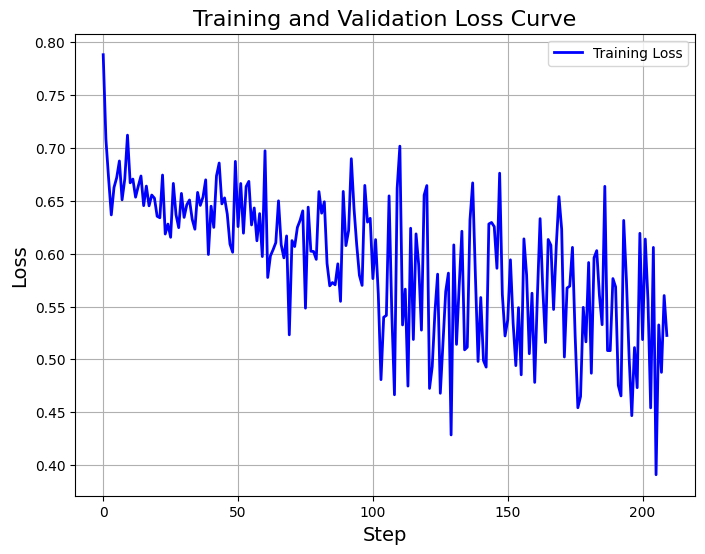

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(loss_trends[0][::100], label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Curve', fontsize=16)
plt.legend()
plt.grid()
plt.show()